In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('./data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/Base.csv
./data/Variant I.csv
./data/Variant II.csv
./data/Variant III.csv
./data/Variant IV.csv
./data/Variant V.csv


In [2]:
import pandas as pd

# Import the datasets
base = pd.read_csv('./data/Base.csv')
variant_1 = pd.read_csv('./data/Variant I.csv')
variant_2 = pd.read_csv('./data/Variant II.csv')
variant_3 = pd.read_csv('./data/Variant III.csv')
variant_4 = pd.read_csv('./data/Variant IV.csv')
variant_5 = pd.read_csv('./data/Variant V.csv')

# Put all datasets in a dictionary for easy iteration
datasets = {
    "Base": base,
    "Variant I": variant_1,
    "Variant II": variant_2,
    "Variant III": variant_3,
    "Variant IV": variant_4,
    "Variant V": variant_5,
}

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

datasets = {
    "Base": base,
    "Variant I": variant_1,
    "Variant II": variant_2,
    "Variant III": variant_3,
    "Variant IV": variant_4,
    "Variant V": variant_5,
}

train_test_data = {}

# Process each dataset
for name, data_raw in datasets.items():
    print(f"Processing Dataset: {name}")
    
    # Check column names

    # Verify if target column exists
    target_variable = 'fraud_bool'
    if target_variable not in data_raw.columns:
        raise ValueError(f"'{target_variable}' column not found in {name} dataset. Please check the column name.")

    # Balance the dataset by downsampling the majority class
    df_fraud = data_raw[data_raw[target_variable] == 1]
    df_non_fraud = data_raw[data_raw[target_variable] == 0]
    
    df_non_fraud_downsampled = resample(df_non_fraud,
                                        replace=False,
                                        n_samples=len(df_fraud),
                                        random_state=42)
    
    # Combine the minority and downsampled majority class
    df_balanced = pd.concat([df_fraud, df_non_fraud_downsampled])
    
    # Shuffle the dataset and reset the index
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Verify that 'month' column exists
    if 'month' not in df_balanced.columns:
        raise ValueError(f"'month' column not found in {name} dataset. Please check the column name.")

    # Split the data into train and test based on the "month" feature
    train_data = df_balanced[df_balanced['month'].between(0, 5)]
    test_data = df_balanced[df_balanced['month'].between(6, 7)]
    
    # Drop the "month" feature from train and test sets
    train_data = train_data.drop(columns=['month'])
    test_data = test_data.drop(columns=['month'])
    
    # Reset index
    train_data.reset_index(drop=True, inplace=True)
    test_data.reset_index(drop=True, inplace=True)
    
    # Separate features and target variable
    X_train = train_data.drop(columns=[target_variable])
    y_train = train_data[target_variable]
    X_test = test_data.drop(columns=[target_variable])
    y_test = test_data[target_variable]

    # Correctly identify numerical and categorical features after dropping 'month'
    numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Check feature columns before pre-processing
    
    # Update ColumnTransformer with correct feature names
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(sparse_output=False, drop='first'), categorical_features)
        ]
    )
    
    # Apply the ColumnTransformer
    try:
        X_train_transformed = preprocessor.fit_transform(X_train)
        X_test_transformed = preprocessor.transform(X_test)
    except KeyError as e:
        print(f"KeyError: {e}")
        print(f"Numerical Features: {numerical_features}")
        print(f"Categorical Features: {categorical_features}")
        raise ValueError("A given column is not a column of the dataframe. Check the feature definitions.")
    
    # Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)
    
    # Store transformed datasets
    train_test_data[name] = {
        'X_train': X_train_resampled,
        'X_test': X_test_transformed,
        'y_train': y_train_resampled,
        'y_test': y_test,
        'X_test_raw': X_test,  # Save raw data for bias analysis
        'preprocessor': preprocessor  # Save preprocessor for inverse transform or further processing
    }

print("Data Transformation Completed for All Variants.")


Processing Dataset: Base
Processing Dataset: Variant I
Processing Dataset: Variant II
Processing Dataset: Variant III
Processing Dataset: Variant IV
Processing Dataset: Variant V
Data Transformation Completed for All Variants.


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Define models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
}

trained_models = {}

# Train models for each dataset
for dataset_name, data in train_test_data.items():
    for model_name, model in models.items():
        print(f"Training {model_name} on {dataset_name} dataset...")
        
        # Train the model
        model.fit(data['X_train'], data['y_train'])
        
        # Store the trained model
        trained_models[(dataset_name, model_name)] = model


Training Logistic Regression on Base dataset...
Training KNN on Base dataset...
Training Random Forest on Base dataset...
Training Naive Bayes on Base dataset...
Training Logistic Regression on Variant I dataset...
Training KNN on Variant I dataset...
Training Random Forest on Variant I dataset...
Training Naive Bayes on Variant I dataset...
Training Logistic Regression on Variant II dataset...
Training KNN on Variant II dataset...
Training Random Forest on Variant II dataset...
Training Naive Bayes on Variant II dataset...
Training Logistic Regression on Variant III dataset...
Training KNN on Variant III dataset...
Training Random Forest on Variant III dataset...
Training Naive Bayes on Variant III dataset...
Training Logistic Regression on Variant IV dataset...
Training KNN on Variant IV dataset...
Training Random Forest on Variant IV dataset...
Training Naive Bayes on Variant IV dataset...
Training Logistic Regression on Variant V dataset...
Training KNN on Variant V dataset...
Trai

In [5]:
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 5.3 MB/s eta 0:00:00ta 0:00:01


Training and Evaluating Logistic Regression on Base dataset...


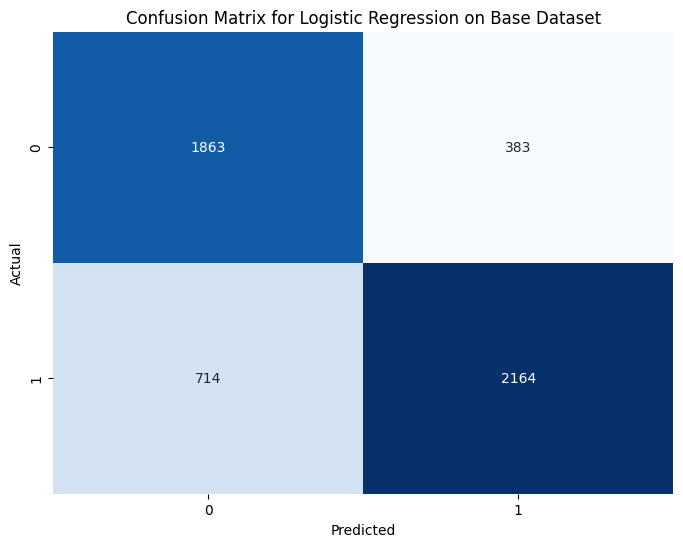

Classification Report for Logistic Regression on Base Dataset:
              precision    recall  f1-score   support

           0       0.72      0.83      0.77      2246
           1       0.85      0.75      0.80      2878

    accuracy                           0.79      5124
   macro avg       0.79      0.79      0.79      5124
weighted avg       0.79      0.79      0.79      5124

ROC-AUC Score for Logistic Regression on Base Dataset: 0.87
Training and Evaluating KNN on Base dataset...


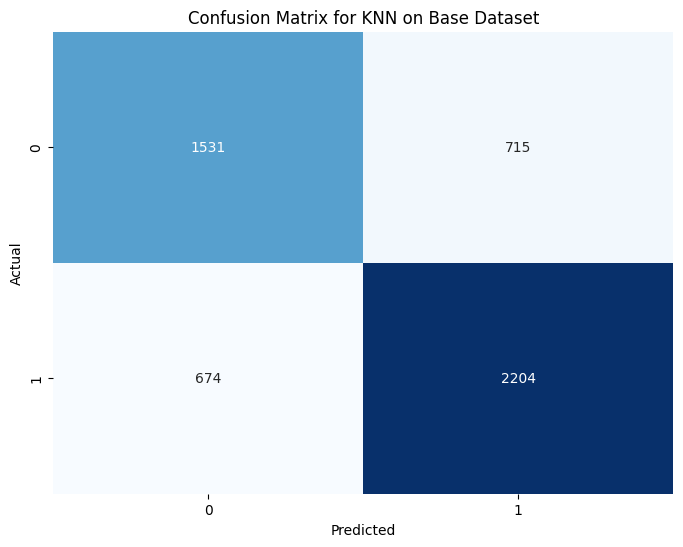

Classification Report for KNN on Base Dataset:
              precision    recall  f1-score   support

           0       0.69      0.68      0.69      2246
           1       0.76      0.77      0.76      2878

    accuracy                           0.73      5124
   macro avg       0.72      0.72      0.72      5124
weighted avg       0.73      0.73      0.73      5124

ROC-AUC Score for KNN on Base Dataset: 0.78
Training and Evaluating Random Forest on Base dataset...


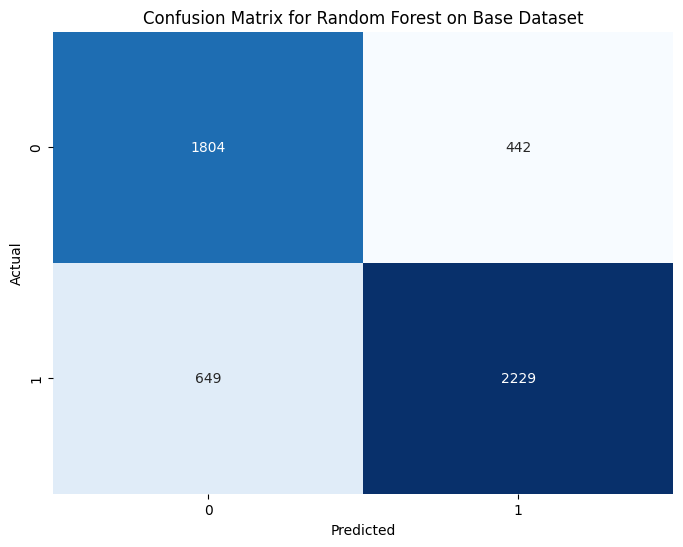

Classification Report for Random Forest on Base Dataset:
              precision    recall  f1-score   support

           0       0.74      0.80      0.77      2246
           1       0.83      0.77      0.80      2878

    accuracy                           0.79      5124
   macro avg       0.78      0.79      0.79      5124
weighted avg       0.79      0.79      0.79      5124

ROC-AUC Score for Random Forest on Base Dataset: 0.87
Training and Evaluating Naive Bayes on Base dataset...


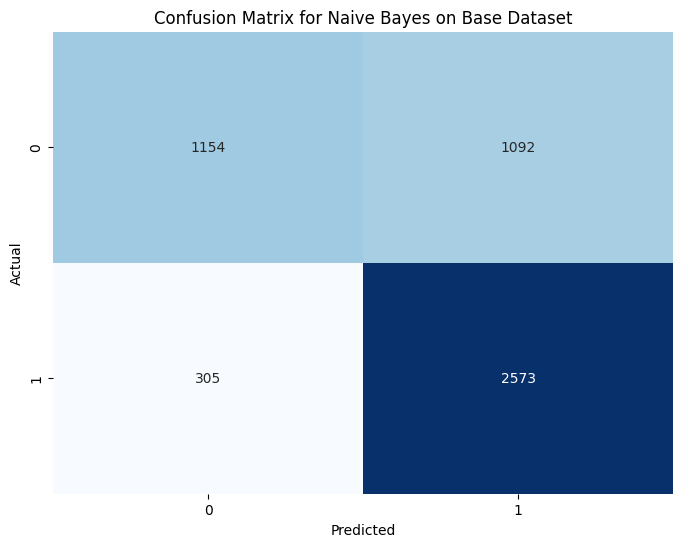

Classification Report for Naive Bayes on Base Dataset:
              precision    recall  f1-score   support

           0       0.79      0.51      0.62      2246
           1       0.70      0.89      0.79      2878

    accuracy                           0.73      5124
   macro avg       0.75      0.70      0.70      5124
weighted avg       0.74      0.73      0.71      5124

ROC-AUC Score for Naive Bayes on Base Dataset: 0.82
Training and Evaluating Logistic Regression on Variant I dataset...


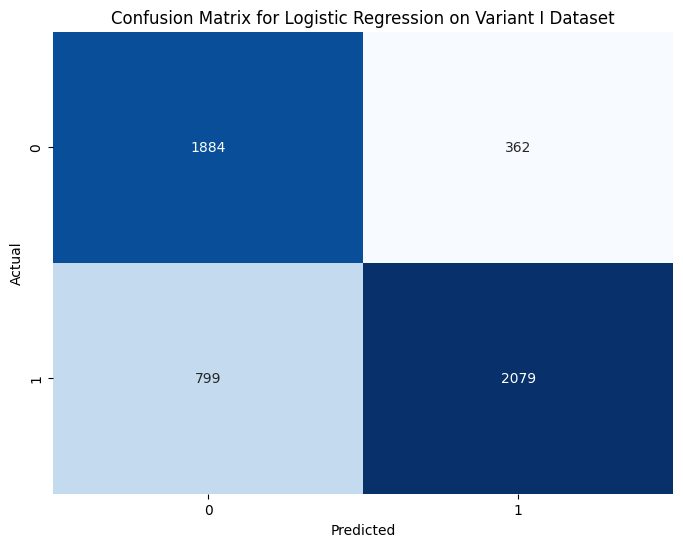

Classification Report for Logistic Regression on Variant I Dataset:
              precision    recall  f1-score   support

           0       0.70      0.84      0.76      2246
           1       0.85      0.72      0.78      2878

    accuracy                           0.77      5124
   macro avg       0.78      0.78      0.77      5124
weighted avg       0.79      0.77      0.77      5124

ROC-AUC Score for Logistic Regression on Variant I Dataset: 0.87
Training and Evaluating KNN on Variant I dataset...


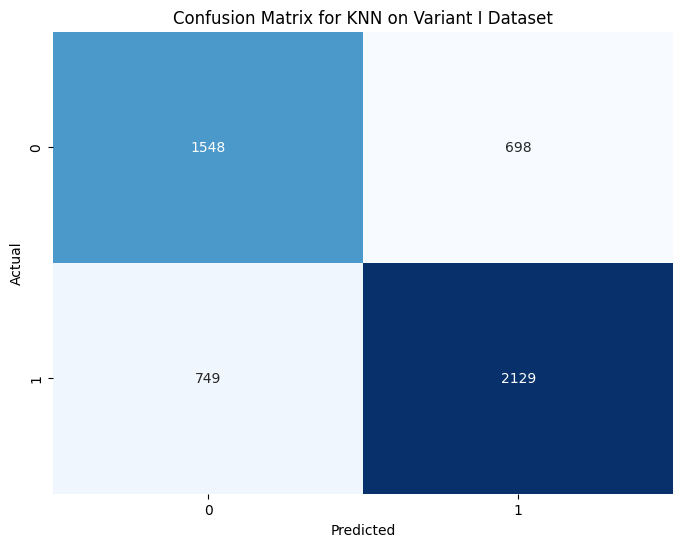

Classification Report for KNN on Variant I Dataset:
              precision    recall  f1-score   support

           0       0.67      0.69      0.68      2246
           1       0.75      0.74      0.75      2878

    accuracy                           0.72      5124
   macro avg       0.71      0.71      0.71      5124
weighted avg       0.72      0.72      0.72      5124

ROC-AUC Score for KNN on Variant I Dataset: 0.78
Training and Evaluating Random Forest on Variant I dataset...


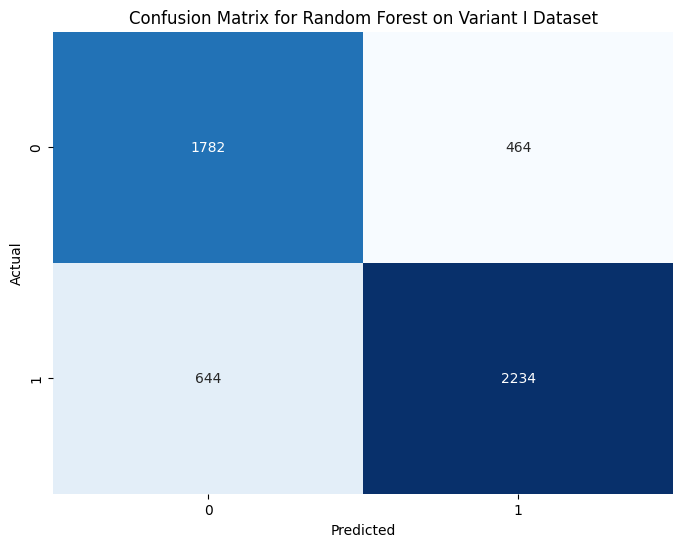

Classification Report for Random Forest on Variant I Dataset:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76      2246
           1       0.83      0.78      0.80      2878

    accuracy                           0.78      5124
   macro avg       0.78      0.78      0.78      5124
weighted avg       0.79      0.78      0.78      5124

ROC-AUC Score for Random Forest on Variant I Dataset: 0.87
Training and Evaluating Naive Bayes on Variant I dataset...


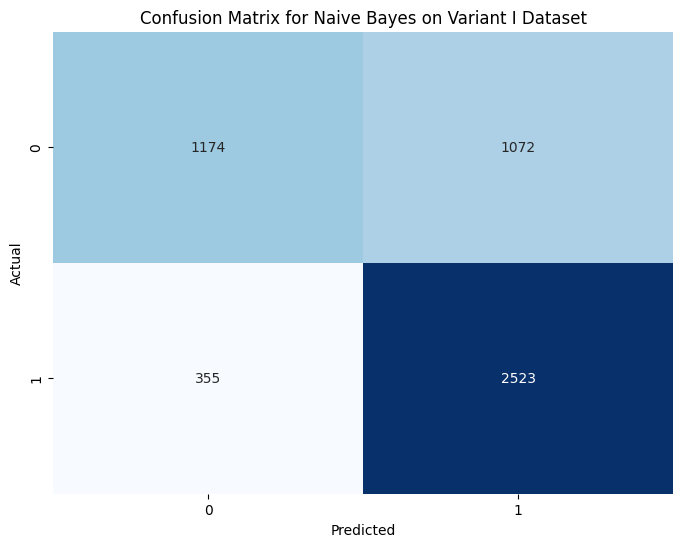

Classification Report for Naive Bayes on Variant I Dataset:
              precision    recall  f1-score   support

           0       0.77      0.52      0.62      2246
           1       0.70      0.88      0.78      2878

    accuracy                           0.72      5124
   macro avg       0.73      0.70      0.70      5124
weighted avg       0.73      0.72      0.71      5124

ROC-AUC Score for Naive Bayes on Variant I Dataset: 0.81
Training and Evaluating Logistic Regression on Variant II dataset...


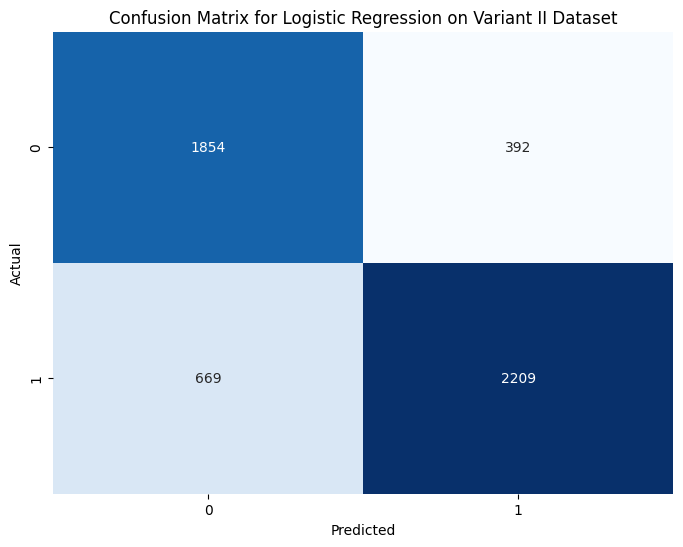

Classification Report for Logistic Regression on Variant II Dataset:
              precision    recall  f1-score   support

           0       0.73      0.83      0.78      2246
           1       0.85      0.77      0.81      2878

    accuracy                           0.79      5124
   macro avg       0.79      0.80      0.79      5124
weighted avg       0.80      0.79      0.79      5124

ROC-AUC Score for Logistic Regression on Variant II Dataset: 0.88
Training and Evaluating KNN on Variant II dataset...


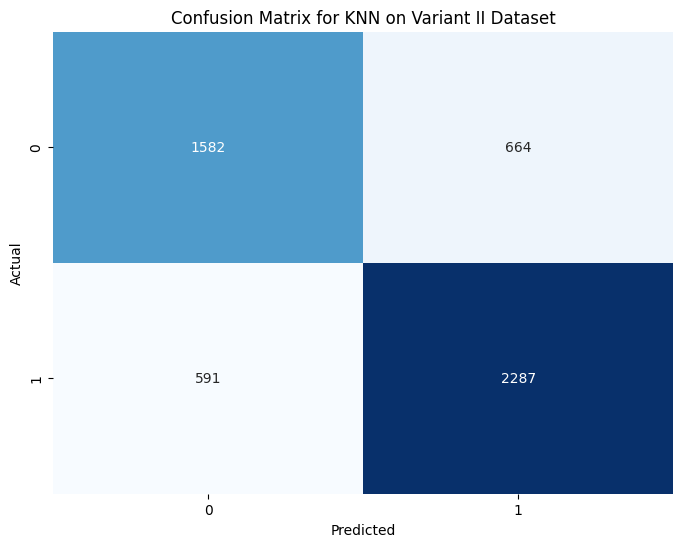

Classification Report for KNN on Variant II Dataset:
              precision    recall  f1-score   support

           0       0.73      0.70      0.72      2246
           1       0.77      0.79      0.78      2878

    accuracy                           0.76      5124
   macro avg       0.75      0.75      0.75      5124
weighted avg       0.75      0.76      0.75      5124

ROC-AUC Score for KNN on Variant II Dataset: 0.80
Training and Evaluating Random Forest on Variant II dataset...


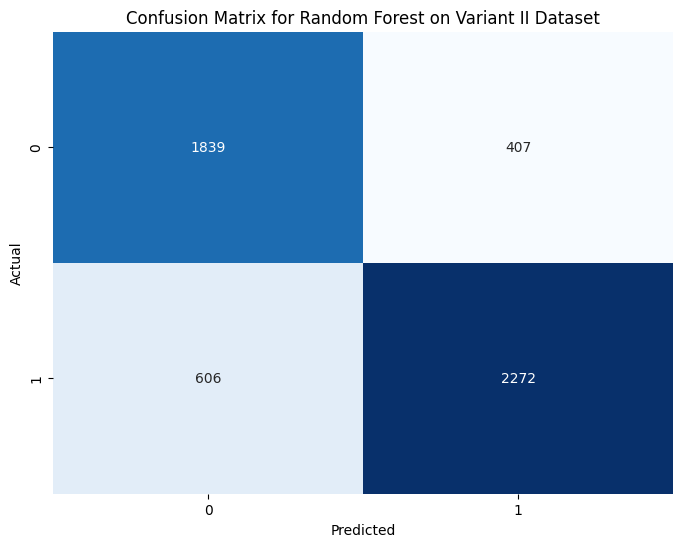

Classification Report for Random Forest on Variant II Dataset:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      2246
           1       0.85      0.79      0.82      2878

    accuracy                           0.80      5124
   macro avg       0.80      0.80      0.80      5124
weighted avg       0.81      0.80      0.80      5124

ROC-AUC Score for Random Forest on Variant II Dataset: 0.88
Training and Evaluating Naive Bayes on Variant II dataset...


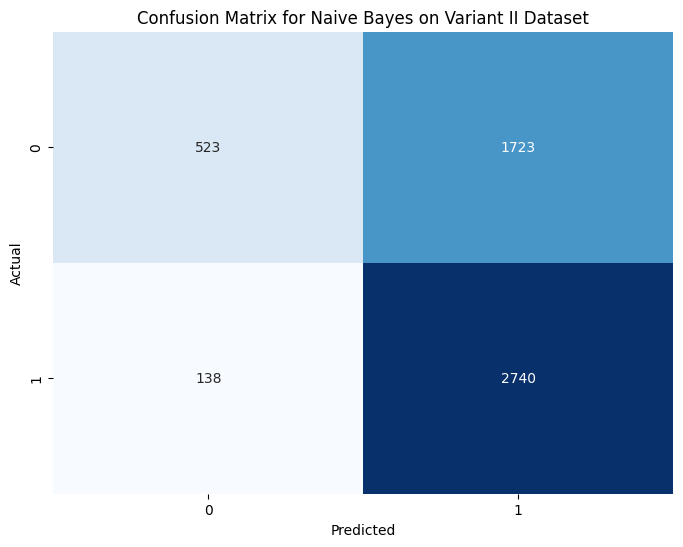

Classification Report for Naive Bayes on Variant II Dataset:
              precision    recall  f1-score   support

           0       0.79      0.23      0.36      2246
           1       0.61      0.95      0.75      2878

    accuracy                           0.64      5124
   macro avg       0.70      0.59      0.55      5124
weighted avg       0.69      0.64      0.58      5124

ROC-AUC Score for Naive Bayes on Variant II Dataset: 0.82
Training and Evaluating Logistic Regression on Variant III dataset...


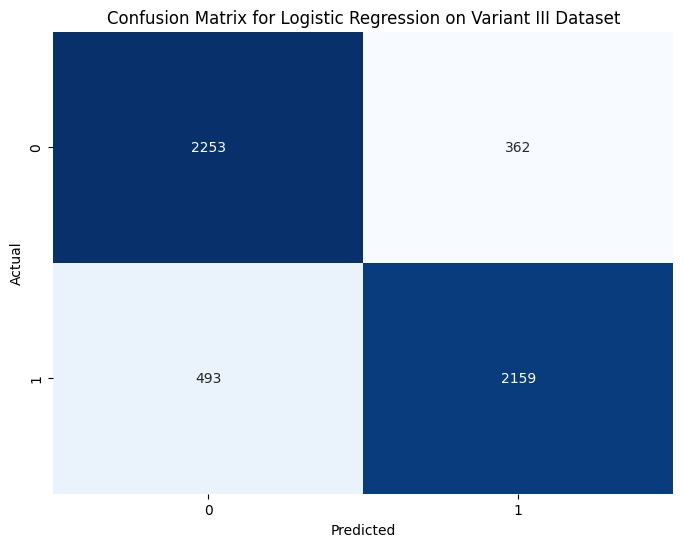

Classification Report for Logistic Regression on Variant III Dataset:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      2615
           1       0.86      0.81      0.83      2652

    accuracy                           0.84      5267
   macro avg       0.84      0.84      0.84      5267
weighted avg       0.84      0.84      0.84      5267

ROC-AUC Score for Logistic Regression on Variant III Dataset: 0.92
Training and Evaluating KNN on Variant III dataset...


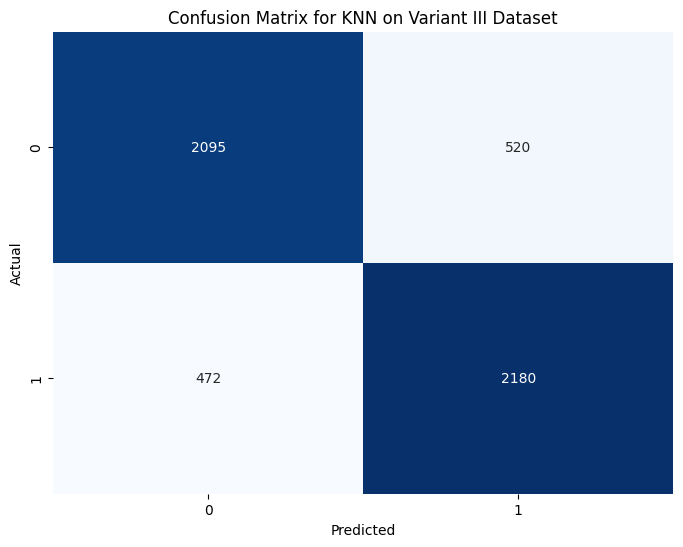

Classification Report for KNN on Variant III Dataset:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      2615
           1       0.81      0.82      0.81      2652

    accuracy                           0.81      5267
   macro avg       0.81      0.81      0.81      5267
weighted avg       0.81      0.81      0.81      5267

ROC-AUC Score for KNN on Variant III Dataset: 0.88
Training and Evaluating Random Forest on Variant III dataset...


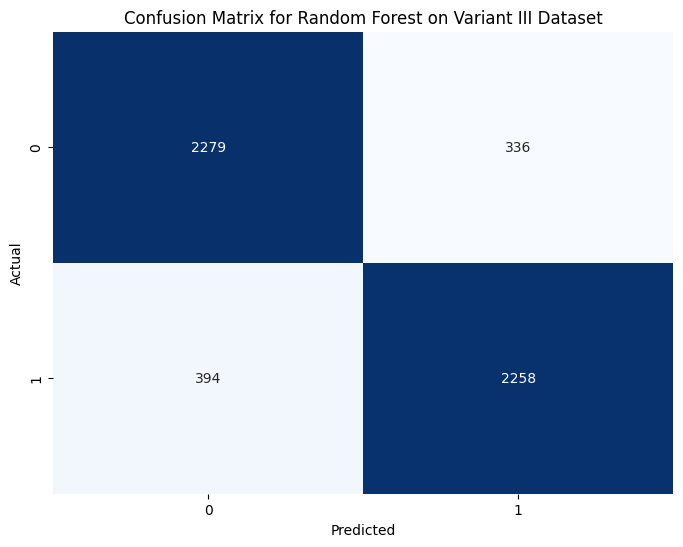

Classification Report for Random Forest on Variant III Dataset:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      2615
           1       0.87      0.85      0.86      2652

    accuracy                           0.86      5267
   macro avg       0.86      0.86      0.86      5267
weighted avg       0.86      0.86      0.86      5267

ROC-AUC Score for Random Forest on Variant III Dataset: 0.94
Training and Evaluating Naive Bayes on Variant III dataset...


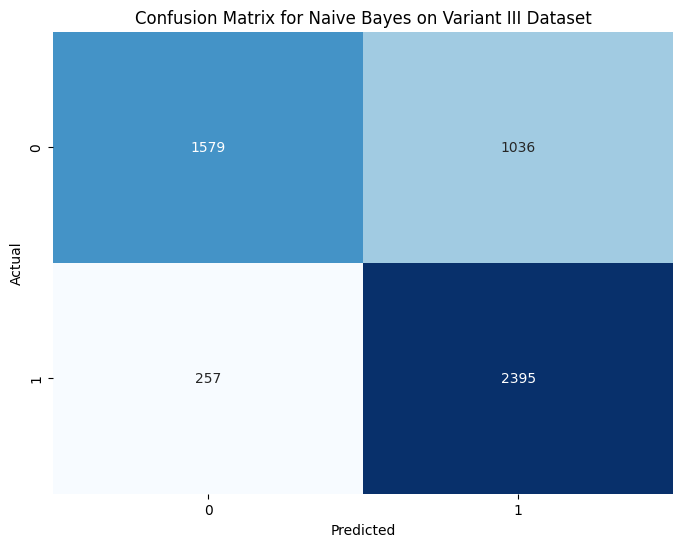

Classification Report for Naive Bayes on Variant III Dataset:
              precision    recall  f1-score   support

           0       0.86      0.60      0.71      2615
           1       0.70      0.90      0.79      2652

    accuracy                           0.75      5267
   macro avg       0.78      0.75      0.75      5267
weighted avg       0.78      0.75      0.75      5267

ROC-AUC Score for Naive Bayes on Variant III Dataset: 0.86
Training and Evaluating Logistic Regression on Variant IV dataset...


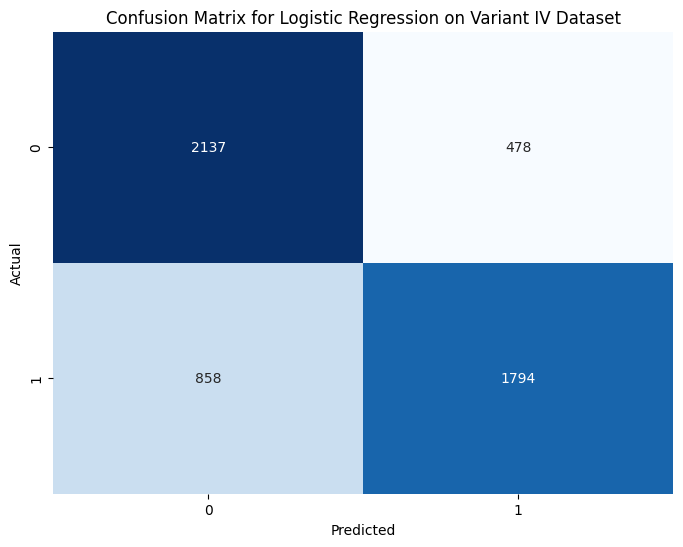

Classification Report for Logistic Regression on Variant IV Dataset:
              precision    recall  f1-score   support

           0       0.71      0.82      0.76      2615
           1       0.79      0.68      0.73      2652

    accuracy                           0.75      5267
   macro avg       0.75      0.75      0.75      5267
weighted avg       0.75      0.75      0.75      5267

ROC-AUC Score for Logistic Regression on Variant IV Dataset: 0.83
Training and Evaluating KNN on Variant IV dataset...


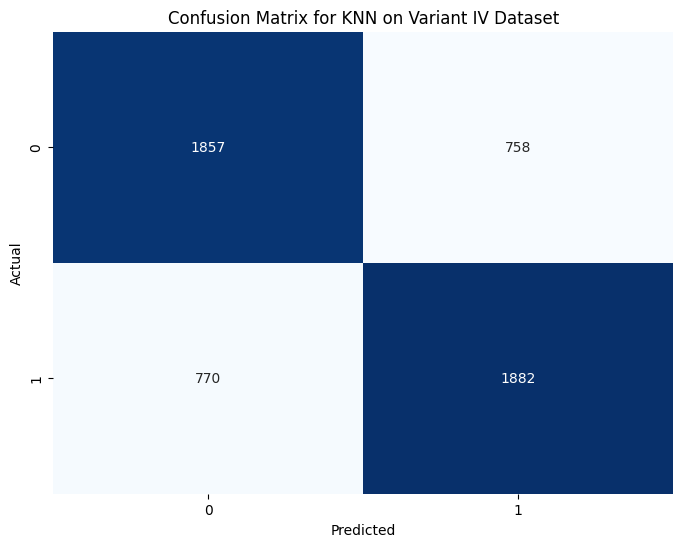

Classification Report for KNN on Variant IV Dataset:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      2615
           1       0.71      0.71      0.71      2652

    accuracy                           0.71      5267
   macro avg       0.71      0.71      0.71      5267
weighted avg       0.71      0.71      0.71      5267

ROC-AUC Score for KNN on Variant IV Dataset: 0.76
Training and Evaluating Random Forest on Variant IV dataset...


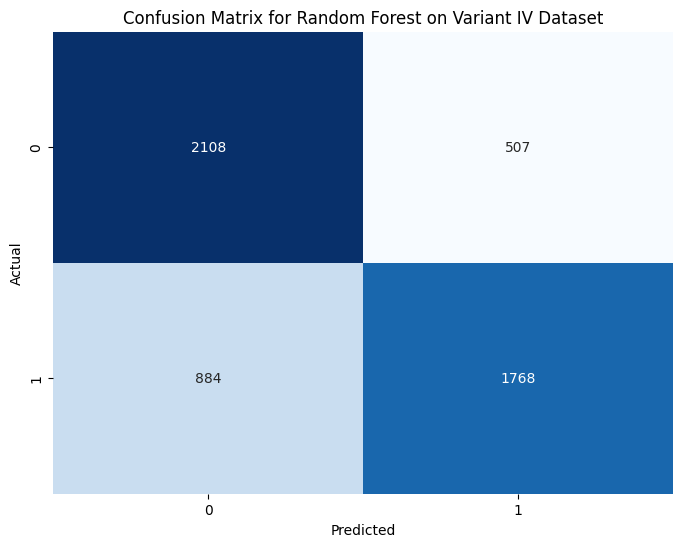

Classification Report for Random Forest on Variant IV Dataset:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75      2615
           1       0.78      0.67      0.72      2652

    accuracy                           0.74      5267
   macro avg       0.74      0.74      0.73      5267
weighted avg       0.74      0.74      0.73      5267

ROC-AUC Score for Random Forest on Variant IV Dataset: 0.82
Training and Evaluating Naive Bayes on Variant IV dataset...


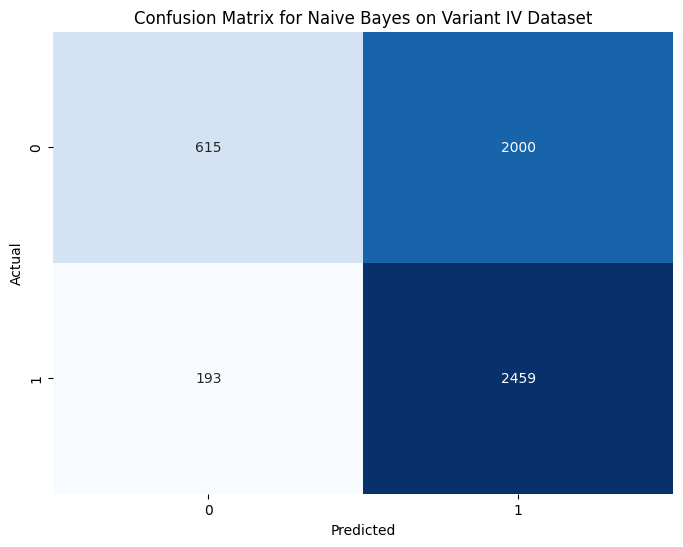

Classification Report for Naive Bayes on Variant IV Dataset:
              precision    recall  f1-score   support

           0       0.76      0.24      0.36      2615
           1       0.55      0.93      0.69      2652

    accuracy                           0.58      5267
   macro avg       0.66      0.58      0.53      5267
weighted avg       0.66      0.58      0.53      5267

ROC-AUC Score for Naive Bayes on Variant IV Dataset: 0.77
Training and Evaluating Logistic Regression on Variant V dataset...


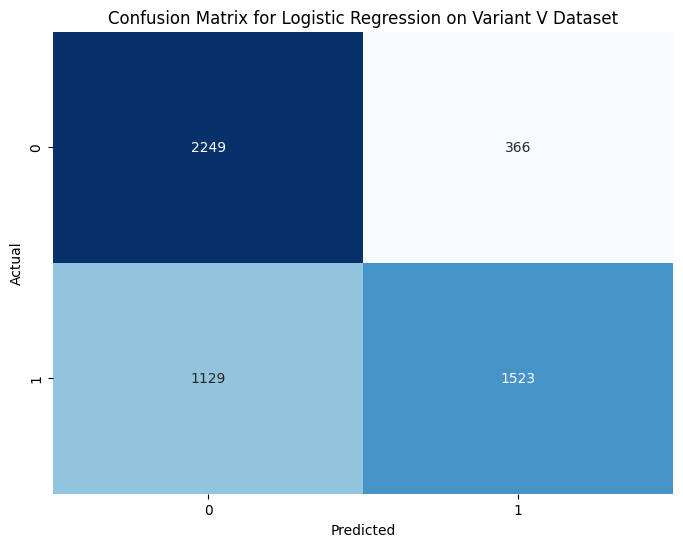

Classification Report for Logistic Regression on Variant V Dataset:
              precision    recall  f1-score   support

           0       0.67      0.86      0.75      2615
           1       0.81      0.57      0.67      2652

    accuracy                           0.72      5267
   macro avg       0.74      0.72      0.71      5267
weighted avg       0.74      0.72      0.71      5267

ROC-AUC Score for Logistic Regression on Variant V Dataset: 0.81
Training and Evaluating KNN on Variant V dataset...


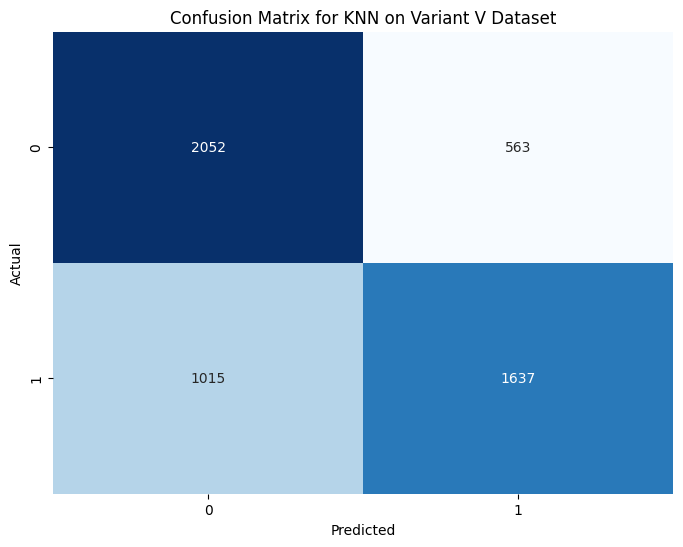

Classification Report for KNN on Variant V Dataset:
              precision    recall  f1-score   support

           0       0.67      0.78      0.72      2615
           1       0.74      0.62      0.67      2652

    accuracy                           0.70      5267
   macro avg       0.71      0.70      0.70      5267
weighted avg       0.71      0.70      0.70      5267

ROC-AUC Score for KNN on Variant V Dataset: 0.76
Training and Evaluating Random Forest on Variant V dataset...


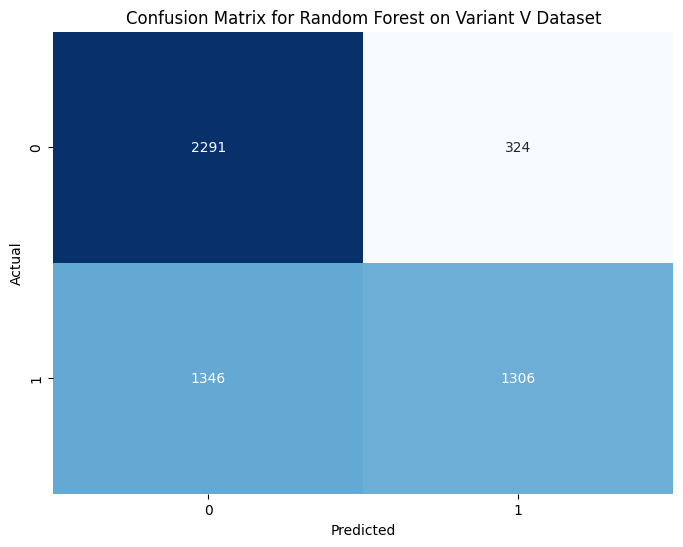

Classification Report for Random Forest on Variant V Dataset:
              precision    recall  f1-score   support

           0       0.63      0.88      0.73      2615
           1       0.80      0.49      0.61      2652

    accuracy                           0.68      5267
   macro avg       0.72      0.68      0.67      5267
weighted avg       0.72      0.68      0.67      5267

ROC-AUC Score for Random Forest on Variant V Dataset: 0.78
Training and Evaluating Naive Bayes on Variant V dataset...


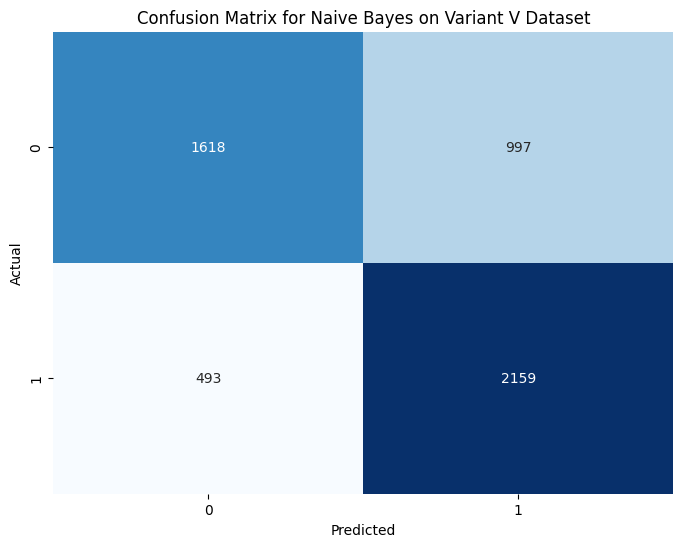

Classification Report for Naive Bayes on Variant V Dataset:
              precision    recall  f1-score   support

           0       0.77      0.62      0.68      2615
           1       0.68      0.81      0.74      2652

    accuracy                           0.72      5267
   macro avg       0.73      0.72      0.71      5267
weighted avg       0.72      0.72      0.71      5267

ROC-AUC Score for Naive Bayes on Variant V Dataset: 0.79

All Metrics Summary:
        Dataset                Model  Accuracy  F1 Score  ROC-AUC Score  \
0          Base  Logistic Regression  0.785909  0.797788       0.873911   
1          Base                  KNN  0.728923  0.760393       0.781780   
2          Base        Random Forest  0.787080  0.803388       0.866166   
3          Base          Naive Bayes  0.727361  0.786489       0.815131   
4     Variant I  Logistic Regression  0.773419  0.781726       0.866055   
5     Variant I                  KNN  0.717603  0.746363       0.777822   
6     Var

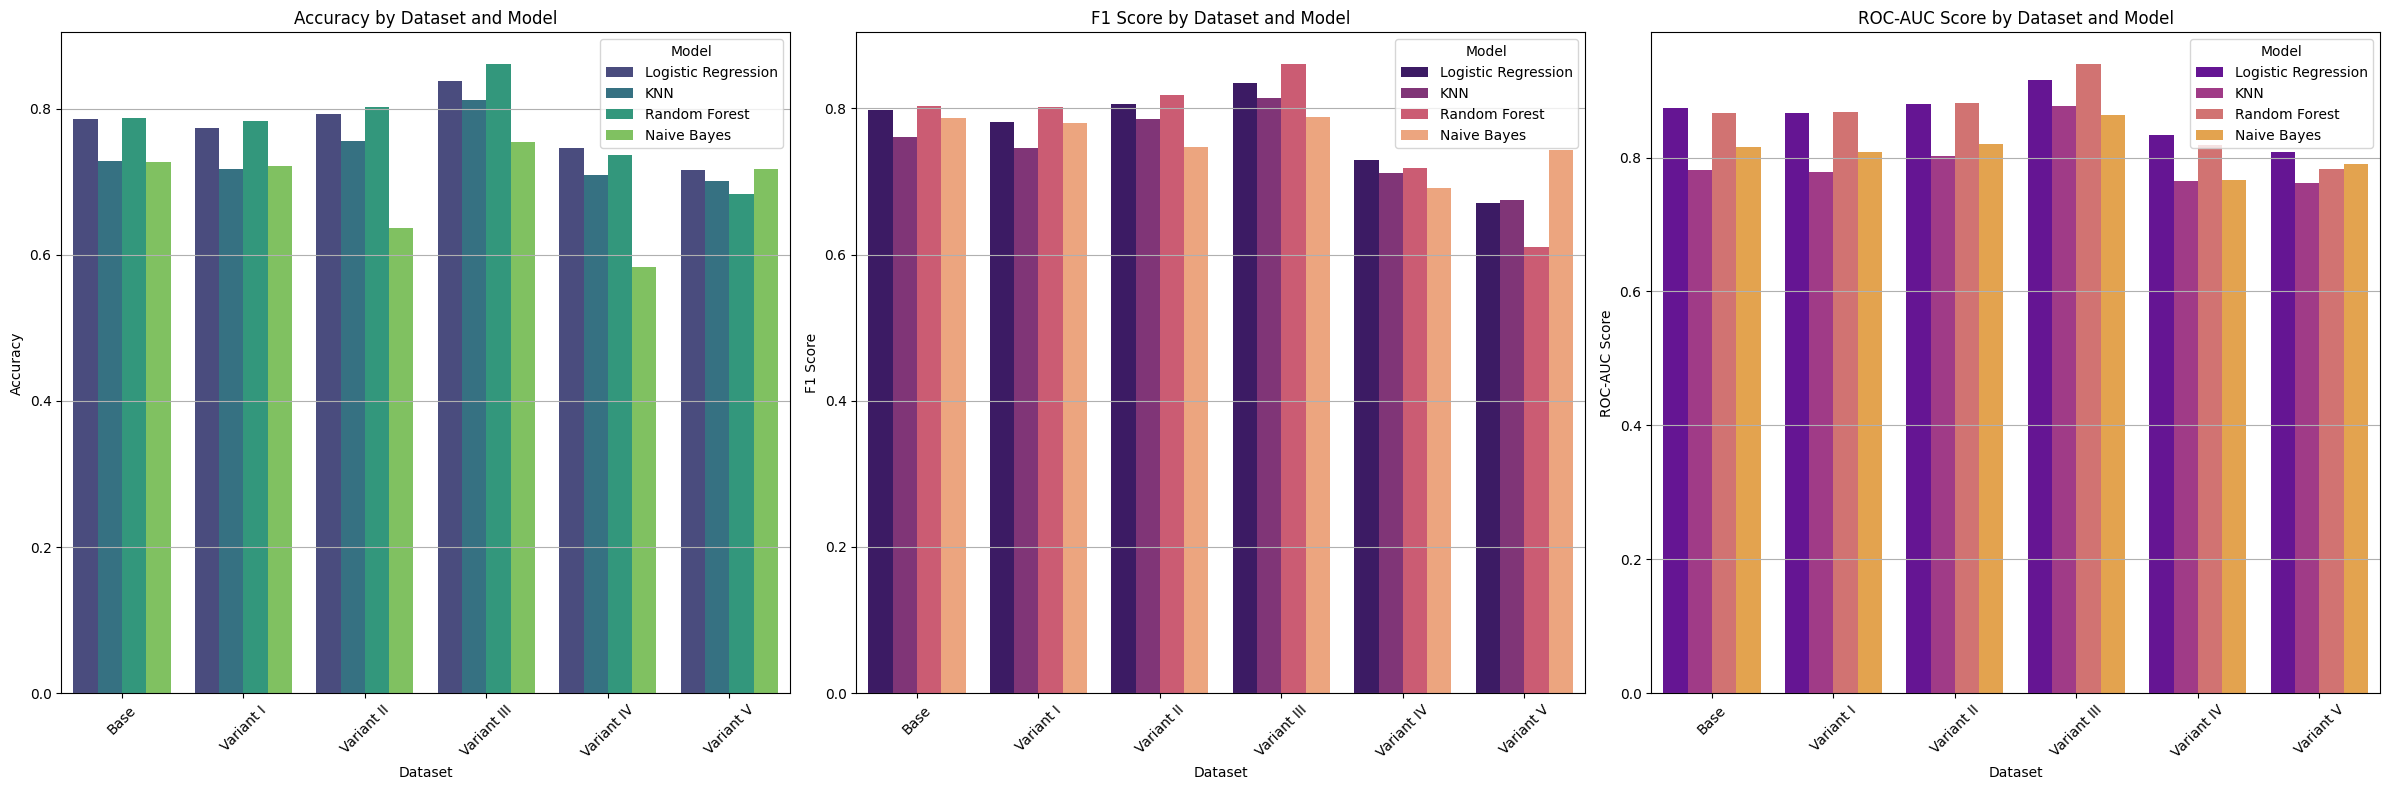

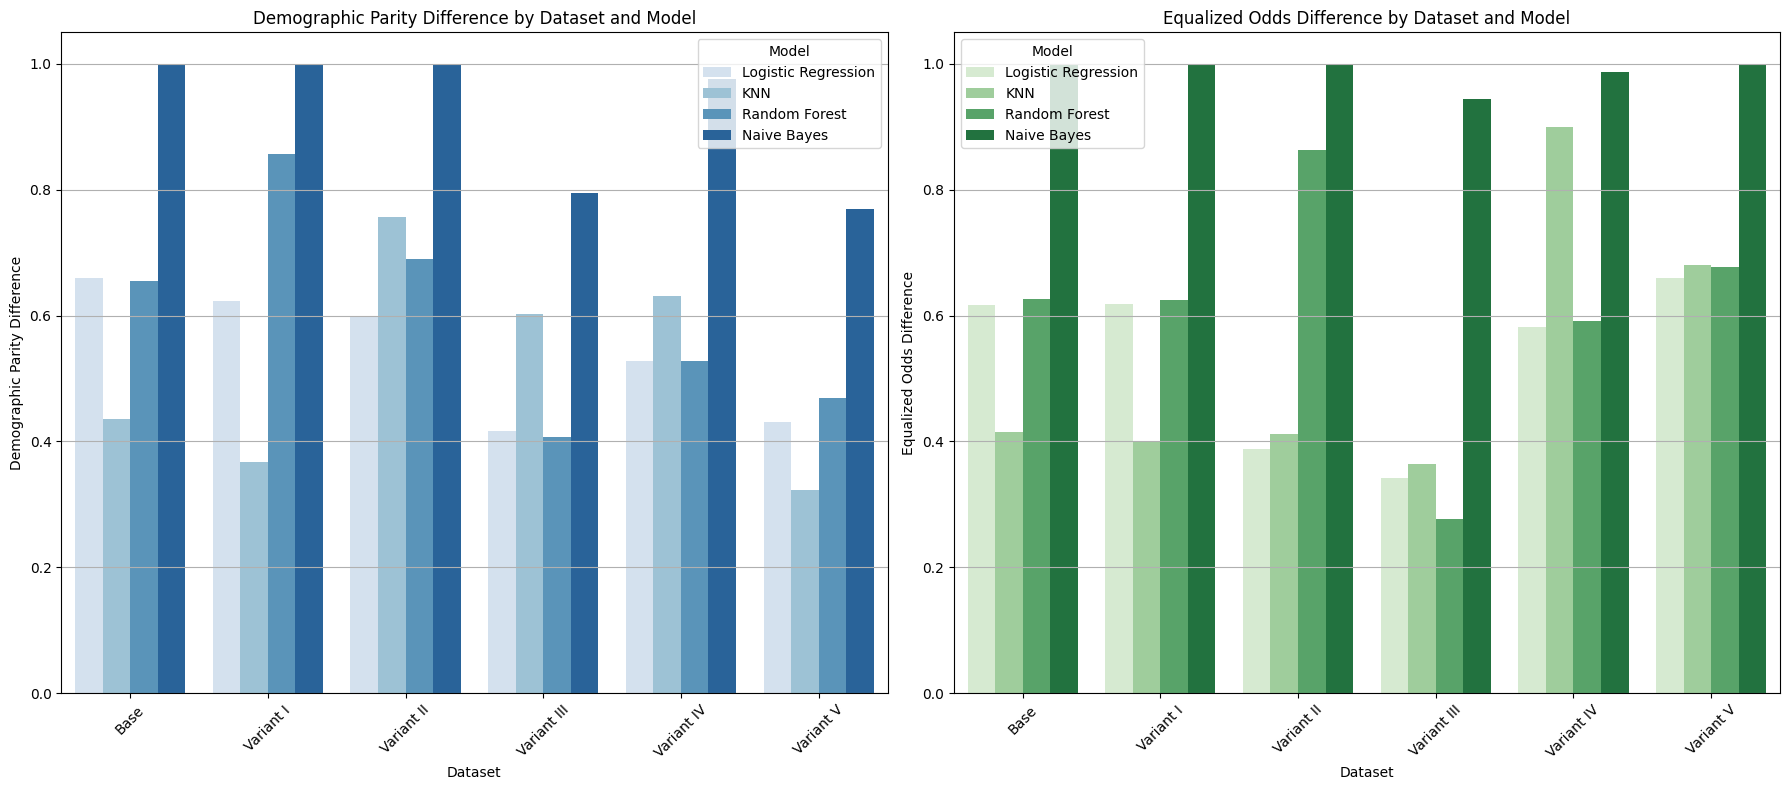

In [6]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

# Lists to store test and bias results
all_metrics_results = []
bias_metrics_results = []

# Iterate through each dataset and model to test them
for dataset_name, data in train_test_data.items():
    for model_name, model in models.items():
        print(f"Training and Evaluating {model_name} on {dataset_name} dataset...")

        # Train the model
        model.fit(data['X_train'], data['y_train'])  # Train on the resampled training data

        # Make predictions
        y_test_pred = model.predict(data['X_test'])
        y_test_prob = model.predict_proba(data['X_test'])[:, 1] if hasattr(model, "predict_proba") else None
        
        # Calculate metrics
        cm = confusion_matrix(data['y_test'], y_test_pred)
        report = classification_report(data['y_test'], y_test_pred, output_dict=True)
        roc_auc = roc_auc_score(data['y_test'], y_test_prob) if y_test_prob is not None else 'N/A'

        # Print Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Confusion Matrix for {model_name} on {dataset_name} Dataset")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        # Print Classification Report and ROC-AUC
        print(f"Classification Report for {model_name} on {dataset_name} Dataset:")
        print(classification_report(data['y_test'], y_test_pred))
        if y_test_prob is not None:
            print(f"ROC-AUC Score for {model_name} on {dataset_name} Dataset: {roc_auc:.2f}")
        else:
            print(f"ROC-AUC Score for {model_name} on {dataset_name} Dataset: Not Applicable")

        # Calculate performance metrics
        accuracy = accuracy_score(data['y_test'], y_test_pred)
        f1 = f1_score(data['y_test'], y_test_pred)
        roc_auc = roc_auc_score(data['y_test'], y_test_prob) if y_test_prob is not None else 'N/A'

        # Fairness metrics evaluation
        sensitive_attribute = 'employment_status'
        if sensitive_attribute not in data['X_test_raw'].columns:
            raise ValueError(f"'{sensitive_attribute}' column not found in {dataset_name} dataset for bias evaluation.")

        sensitive_features = data['X_test_raw'][sensitive_attribute]

        # Calculate Demographic Parity Difference
        dp_diff = demographic_parity_difference(data['y_test'], y_test_pred, sensitive_features=sensitive_features)

        # Calculate Equalized Odds Difference
        eo_diff = equalized_odds_difference(data['y_test'], y_test_pred, sensitive_features=sensitive_features)

        # Store all metrics results
        all_metrics_results.append({
            'Dataset': dataset_name,
            'Model': model_name,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'ROC-AUC Score': roc_auc,
            'Demographic Parity Difference': dp_diff,
            'Equalized Odds Difference': eo_diff
        })

        # Store bias metrics separately for plotting
        bias_metrics_results.append({
            'Dataset': dataset_name,
            'Model': model_name,
            'Demographic Parity Difference': dp_diff,
            'Equalized Odds Difference': eo_diff
        })

# Convert all metrics results to DataFrame for visualization
all_metrics_df = pd.DataFrame(all_metrics_results)
bias_summary = pd.DataFrame(bias_metrics_results)

# Print All Metrics Summary
print("\nAll Metrics Summary:")
print(all_metrics_df)

# Plotting All Metrics Summary
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# Plot Accuracy for all datasets and models
sns.barplot(data=all_metrics_df, x='Dataset', y='Accuracy', hue='Model', ax=axs[0], palette='viridis')
axs[0].set_title('Accuracy by Dataset and Model')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Dataset')
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(axis='y')

# Plot F1 Score for all datasets and models
sns.barplot(data=all_metrics_df, x='Dataset', y='F1 Score', hue='Model', ax=axs[1], palette='magma')
axs[1].set_title('F1 Score by Dataset and Model')
axs[1].set_ylabel('F1 Score')
axs[1].set_xlabel('Dataset')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y')

# Plot ROC-AUC Score for all datasets and models (if applicable)
sns.barplot(data=all_metrics_df[all_metrics_df['ROC-AUC Score'] != 'N/A'], x='Dataset', y='ROC-AUC Score', hue='Model', ax=axs[2], palette='plasma')
axs[2].set_title('ROC-AUC Score by Dataset and Model')
axs[2].set_ylabel('ROC-AUC Score')
axs[2].set_xlabel('Dataset')
axs[2].tick_params(axis='x', rotation=45)
axs[2].grid(axis='y')

plt.tight_layout()
plt.show()

# Plotting Bias Metrics
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Plot Demographic Parity Difference for all datasets and models
sns.barplot(data=bias_summary, x='Dataset', y='Demographic Parity Difference', hue='Model', ax=axs[0], palette='Blues')
axs[0].set_title('Demographic Parity Difference by Dataset and Model')
axs[0].set_ylabel('Demographic Parity Difference')
axs[0].set_xlabel('Dataset')
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(axis='y')

# Plot Equalized Odds Difference for all datasets and models
sns.barplot(data=bias_summary, x='Dataset', y='Equalized Odds Difference', hue='Model', ax=axs[1], palette='Greens')
axs[1].set_title('Equalized Odds Difference by Dataset and Model')
axs[1].set_ylabel('Equalized Odds Difference')
axs[1].set_xlabel('Dataset')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y')

plt.tight_layout()
plt.show()
